In [4]:
# Clone the dataset repository from GitHub
!git clone https://github.com/linteresa/WiAR.git

Cloning into 'WiAR'...
remote: Enumerating objects: 4016, done.
remote: Total 4016 (delta 0), reused 0 (delta 0), pack-reused 4016 (from 1)
Receiving objects: 100% (4016/4016), 915.94 MiB | 29.42 MiB/s, done.
Resolving deltas: 100% (40/40), done.
Updating files: 100% (2011/2011), done.


In [5]:
# ==============================================================================
# 1. INSTALL DEPENDENCIES
# ==============================================================================
!pip install csiread tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.7/364.7 kB 12.9 MB/s eta 0:00:00


In [6]:
# ==============================================================================
# 2. SETUP & IMPORTS
# ==============================================================================
import os
import warnings
import logging
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, filtfilt
from tqdm.notebook import tqdm  # Use notebook version for Colab
import csiread

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, LSTM, Bidirectional,
    Dense, Dropout, BatchNormalization, Layer
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Configuration to suppress logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["KMP_WARNINGS"] = "0"
warnings.filterwarnings("ignore")
logging.getLogger("tensorflow").setLevel(logging.ERROR)

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow Version: 2.19.0
GPU Available: True


In [7]:
# ==============================================================================
# 3. CUSTOM ATTENTION LAYER
# ==============================================================================
class Attention(Layer):
    """
    Self-Attention Mechanism to weigh important time steps.
    """
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='normal')
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros')
        super(Attention, self).build(input_shape)

    def call(self, x):
        # x shape: (batch, time, features)
        # 1. Calculate scores
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        # 2. Calculate weights (softmax over time axis)
        a = tf.keras.backend.softmax(e, axis=1)
        # 3. Weighted sum
        output = x * a
        return tf.reduce_sum(output, axis=1)

    def get_config(self):
        return super(Attention, self).get_config()

In [8]:
# ==============================================================================
# 4. DATA PROCESSING FUNCTIONS
# ==============================================================================

def load_and_preprocess_file(file_path):
    """
    Load CSI, flatten antenna dims to preserve spatial diversity, apply LPF.
    """
    configs_to_try = [(1, 3), (2, 3), (3, 3)]
    csi_data = None

    for ntx, nrx in configs_to_try:
        try:
            temp_csi = csiread.Intel(file_path, ntxnum=ntx, nrxnum=nrx)
            temp_csi.read()
            if temp_csi.csi is not None and temp_csi.csi.size > 0:
                csi_data = temp_csi
                break
        except Exception:
            continue

    if csi_data is None:
        return None

    csi_complex = csi_data.csi # (N, Nrx, Ntx, Sub)
    csi_complex = np.squeeze(csi_complex)

    # Flatten spatial dimensions: (Time, Features)
    if csi_complex.ndim > 2:
        T = csi_complex.shape[0]
        csi_complex = csi_complex.reshape(T, -1)

    amplitude = np.abs(csi_complex)

    # Low Pass Filter (Butterworth order 6)
    b, a = butter(6, 0.1, btype='low', analog=False)
    filtered = filtfilt(b, a, amplitude, axis=0)

    return filtered

def make_fixed_length_sequence(ts_data, seq_len):
    """
    Ensure fixed sequence length via crop or pad.
    """
    T, F = ts_data.shape

    # Downsample if extremely long
    if T > seq_len * 4:
        factor = T // (seq_len * 4)
        ts_data = ts_data[::factor, :]
        T = ts_data.shape[0]

    if T >= seq_len:
        start = (T - seq_len) // 2
        return ts_data[start:start+seq_len, :]
    else:
        pad = np.zeros((seq_len - T, F), dtype=ts_data.dtype)
        return np.vstack([ts_data, pad])

def augment_data(sequence):
    """
    Add noise and scaling to increase robustness.
    """
    # Jitter
    noise = np.random.normal(0, 0.02, sequence.shape)
    jittered = sequence + noise
    # Scale
    scaling_factor = np.random.normal(loc=1.0, scale=0.1)
    scaled = jittered * scaling_factor
    return scaled

In [9]:
# ==============================================================================
# 5. LOAD RAW DATA
# ==============================================================================

SEQ_LEN = 384

# UPDATE THESE PATHS IF NECESSARY
data_dirs = [
    '/content/WiAR/distance_factor_activity_data/1_alldata',
    '/content/WiAR/distance_factor_activity_data/3_alldata',
    '/content/WiAR/distance_factor_activity_data/6_alldata',
    '/content/WiAR/height_factor_activity_data/60_rawdata',
    '/content/WiAR/height_factor_activity_data/90_rawdata',
    '/content/WiAR/height_factor_activity_data/120_rawdata',
    '/content/WiAR/data/volunteer_a_all_data',
]

X_raw_list = []
y_list = []
label_pattern = re.compile(r'csi_a(\d+)_')

print("Loading RAW Data...")

for directory in data_dirs:
    if not os.path.exists(directory):
        print(f"Warning: Directory not found, skipping: {directory}")
        continue

    print(f"Processing: {directory}")
    files = sorted([f for f in os.listdir(directory) if f.endswith('.dat')])

    for filename in tqdm(files, desc="Loading files"):
        match = label_pattern.search(filename)
        if not match:
            continue

        label = int(match.group(1)) - 1
        file_path = os.path.join(directory, filename)

        ts_data = load_and_preprocess_file(file_path)
        if ts_data is None or ts_data.shape[0] < 10:
            continue

        seq = make_fixed_length_sequence(ts_data, SEQ_LEN)
        X_raw_list.append(seq)
        y_list.append(label)

print(f"Finished loading. Total samples: {len(X_raw_list)}")

Loading RAW Data...
Processing: /content/WiAR/distance_factor_activity_data/1_alldata


Loading files:   0%|          | 0/160 [00:00<?, ?it/s]

Processing: /content/WiAR/distance_factor_activity_data/3_alldata


Loading files:   0%|          | 0/160 [00:00<?, ?it/s]

Processing: /content/WiAR/distance_factor_activity_data/6_alldata


Loading files:   0%|          | 0/160 [00:00<?, ?it/s]

Processing: /content/WiAR/height_factor_activity_data/60_rawdata


Loading files:   0%|          | 0/480 [00:00<?, ?it/s]

Processing: /content/WiAR/height_factor_activity_data/90_rawdata


Loading files:   0%|          | 0/480 [00:00<?, ?it/s]

Processing: /content/WiAR/height_factor_activity_data/120_rawdata


Loading files:   0%|          | 0/480 [00:00<?, ?it/s]

Finished loading. Total samples: 1920


In [10]:
# ==============================================================================
# 6. FEATURE ALIGNMENT
# ==============================================================================

# Find max features (e.g. 270) to handle varying antenna counts
max_features = 0
for seq in X_raw_list:
    if seq.shape[1] > max_features:
        max_features = seq.shape[1]

print(f"Aligning features to max dimension: {max_features}")

X_aligned = []
for seq in X_raw_list:
    T, F = seq.shape
    if F < max_features:
        # Pad features with zeros on the right
        pad_width = ((0, 0), (0, max_features - F))
        seq_padded = np.pad(seq, pad_width, mode='constant')
        X_aligned.append(seq_padded)
    else:
        # Crop if somehow larger (rare)
        X_aligned.append(seq[:, :max_features])

X = np.array(X_aligned, dtype='float32')
y = np.array(y_list, dtype='int32')

print(f"Final Data Shape: {X.shape}")
print(f"Labels Shape: {y.shape}")

Aligning features to max dimension: 180
Final Data Shape: (1920, 384, 180)
Labels Shape: (1920,)


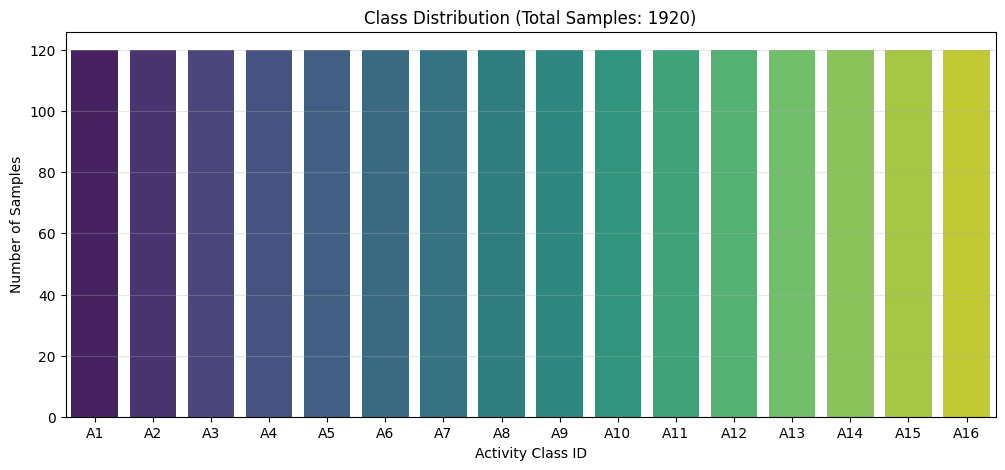

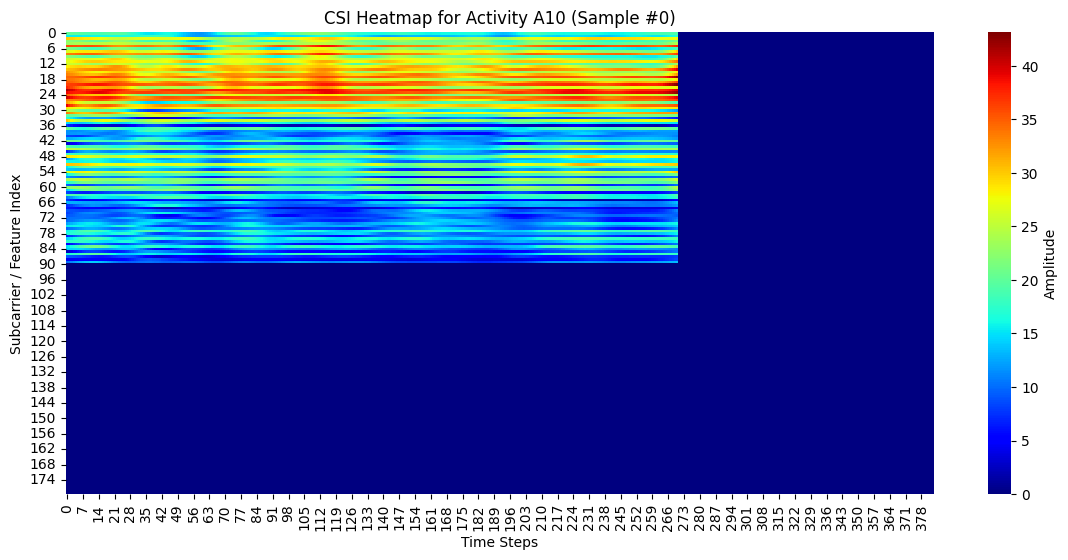

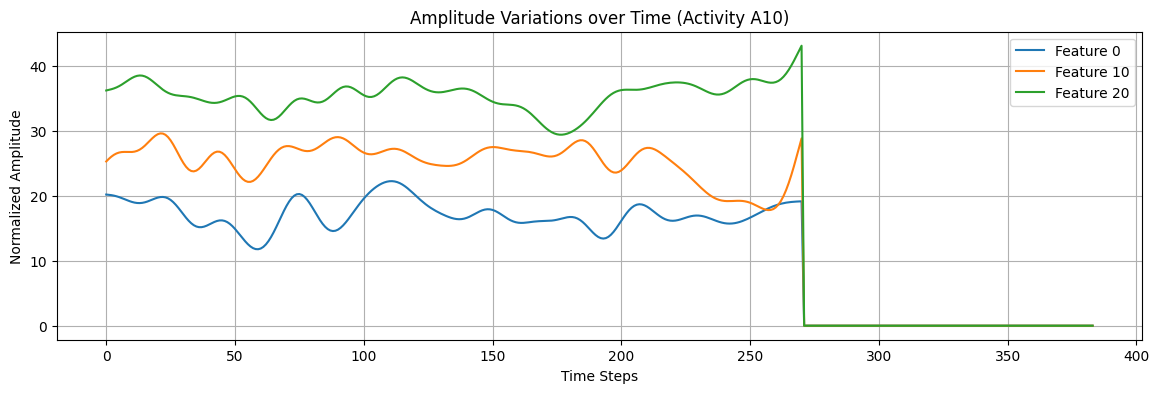

In [11]:
# ==============================================================================
# 6.5 DATA VISUALIZATION & ANALYSIS
# ==============================================================================
import pandas as pd

# 1. CLASS DISTRIBUTION
plt.figure(figsize=(12, 5))
unique, counts = np.unique(y, return_counts=True)
sns.barplot(x=unique, y=counts, palette="viridis")
plt.title(f"Class Distribution (Total Samples: {len(y)})")
plt.xlabel("Activity Class ID")
plt.ylabel("Number of Samples")
plt.xticks(unique, [f"A{i+1}" for i in unique])
plt.grid(axis='y', alpha=0.3)
plt.show()

# 2. CSI SIGNAL HEATMAP (Visualizing one sample)
# We take the first sample from the first class found
sample_idx = 0
sample_seq = X[sample_idx]
sample_label = y[sample_idx]

plt.figure(figsize=(14, 6))
# Transpose to have Subcarriers on Y-axis and Time on X-axis
sns.heatmap(sample_seq.T, cmap="jet", cbar_kws={'label': 'Amplitude'})
plt.title(f"CSI Heatmap for Activity A{sample_label+1} (Sample #{sample_idx})")
plt.xlabel("Time Steps")
plt.ylabel("Subcarrier / Feature Index")
plt.show()

# 3. AMPLITUDE PLOT OF SPECIFIC SUBCARRIERS
# Plotting the 1st, 10th, and 20th feature/subcarrier over time
plt.figure(figsize=(14, 4))
plt.plot(sample_seq[:, 0], label='Feature 0')
plt.plot(sample_seq[:, 10], label='Feature 10')
plt.plot(sample_seq[:, 20], label='Feature 20')
plt.title(f"Amplitude Variations over Time (Activity A{sample_label+1})")
plt.xlabel("Time Steps")
plt.ylabel("Normalized Amplitude")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# ==============================================================================
# 7. SPLIT & NORMALIZE
# ==============================================================================

num_classes = 16
y_cat = to_categorical(y, num_classes=num_classes)

# 1. SPLIT
X_train_raw, X_test, y_train_raw, y_test = train_test_split(
    X, y_cat,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Raw Train Shape: {X_train_raw.shape}")
print(f"Raw Test Shape:  {X_test.shape}")

# 2. INSTANCE NORMALIZATION (Standardize each sample individually)
print("Standardizing data...")

# Normalize Train
mean_train = X_train_raw.mean(axis=(1, 2), keepdims=True)
std_train = X_train_raw.std(axis=(1, 2), keepdims=True) + 1e-6
X_train_raw = (X_train_raw - mean_train) / std_train

# Normalize Test (Using its own stats, as if new real-time data)
mean_test = X_test.mean(axis=(1, 2), keepdims=True)
std_test = X_test.std(axis=(1, 2), keepdims=True) + 1e-6
X_test = (X_test - mean_test) / std_test

print("Normalization complete.")

Raw Train Shape: (1536, 384, 180)
Raw Test Shape:  (384, 384, 180)
Standardizing data...
Normalization complete.


In [13]:
# ==============================================================================
# 8. AUGMENTATION
# ==============================================================================

print("Augmenting Training Data (Creating x2 dataset)...")
X_train_aug = []
y_train_aug = []

for i in tqdm(range(len(X_train_raw)), desc="Augmenting"):
    # Original
    X_train_aug.append(X_train_raw[i])
    y_train_aug.append(y_train_raw[i])

    # Augmented (Noise + Scaling)
    aug = augment_data(X_train_raw[i])
    X_train_aug.append(aug)
    y_train_aug.append(y_train_raw[i])

X_train = np.array(X_train_aug, dtype='float32')
y_train = np.array(y_train_aug, dtype='float32')

print(f"Final Train Shape (after augmentation): {X_train.shape}")

Augmenting Training Data (Creating x2 dataset)...


Augmenting:   0%|          | 0/1536 [00:00<?, ?it/s]

Final Train Shape (after augmentation): (3072, 384, 180)


In [14]:
# ==============================================================================
# 9. BUILD MODEL
# ==============================================================================

def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # --- CNN Block (Extract Spatial Features) ---
    x = Conv1D(64, kernel_size=7, padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.25)(x)

    x = Conv1D(128, kernel_size=5, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.25)(x)

    x = Conv1D(256, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.25)(x)

    # --- BiLSTM Block (Extract Temporal Features) ---
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.4)(x)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Dropout(0.4)(x)

    # --- Attention Block (Focus on important timestamps) ---
    x = Attention()(x)

    # --- Classifier ---
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=inputs, outputs=outputs)

# Construct Model
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_model(input_shape, num_classes)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adamax(learning_rate=1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 384, 180)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 384, 64)        │        80,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 384, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 192, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 192, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 192, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 192, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 96, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 96, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 96, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 48, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 48, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 48, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 48, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 48, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 128)            │           176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 800,000 (3.05 MB)

 Trainable params: 798,848 (3.05 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [15]:
# ==============================================================================
# 10. TRAIN
# ==============================================================================

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True),
    ModelCheckpoint('best_wiar_final.h5', monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1)
]

history = model.fit(
    X_train, y_train,
    epochs=120,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    shuffle=True,
    verbose=1
)

Epoch 1/120
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1539 - loss: 3.1726
Epoch 1: val_accuracy improved from -inf to 0.15885, saving model to best_wiar_final.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.1551 - loss: 3.1652 - val_accuracy: 0.1589 - val_loss: 2.6557 - learning_rate: 0.0010
Epoch 2/120
94/96 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3055 - loss: 2.3329
Epoch 2: val_accuracy improved from 0.15885 to 0.34115, saving model to best_wiar_final.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.3067 - loss: 2.3299 - val_accuracy: 0.3411 - val_loss: 2.3005 - learning_rate: 0.0010
Epoch 3/120
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4559 - loss: 1.9144
Epoch 3: val_accuracy improved from 0.34115 to 0.47135, saving model to best_wiar_final.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.4563 - loss: 1.9136 - val_accuracy: 0.4714 - val_loss: 1.9570 - learning_rate: 0.0010
Epoch 4/120
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5344 - loss: 1.6680
Epoch 4: val_accuracy did not improve from 0.47135
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5347 - loss: 1.6679 - val_accuracy: 0.4219 - val_loss: 1.8972 - learning_rate: 0.0010
Epoch 5/120
94/96 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5932 - loss: 1.5920
Epoch 5: val_accuracy improved from 0.47135 to 0.63021, saving model to best_wiar_final.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5938 - loss: 1.5907 - val_accuracy: 0.6302 - val_loss: 1.5070 - learning_rate: 0.0010
Epoch 6/120
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6492 - loss: 1.4634
Epoch 6: val_accuracy improved from 0.63021 to 0.67708, saving model to best_wiar_final.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.6494 - loss: 1.4628 - val_accuracy: 0.6771 - val_loss: 1.4059 - learning_rate: 0.0010
Epoch 7/120
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7201 - loss: 1.3400
Epoch 7: val_accuracy did not improve from 0.67708
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7199 - loss: 1.3403 - val_accuracy: 0.6016 - val_loss: 1.6122 - learning_rate: 0.0010
Epoch 8/120
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7109 - loss: 1.3235
Epoch 8: val_accuracy did not improve from 0.67708
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7110 - loss: 1.3232 - val_accuracy: 0.5781 - val_loss: 1.7071 - learning_rate: 0.0010
Epoch 9/120
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7686 - loss: 1.2099
Epoch 9: val_accuracy did not improve from 0.67708
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7682 - loss: 1.2103 - val_accuracy: 0.6615 - val_loss: 1.4353 - learning_rate: 0.0010
Epoch 10/120
95/96 ━━━━━━━━━━

96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7865 - loss: 1.1600 - val_accuracy: 0.6979 - val_loss: 1.3615 - learning_rate: 0.0010
Epoch 11/120
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7800 - loss: 1.1817
Epoch 11: val_accuracy did not improve from 0.69792
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7800 - loss: 1.1816 - val_accuracy: 0.6667 - val_loss: 1.4361 - learning_rate: 0.0010
Epoch 12/120
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8095 - loss: 1.1232
Epoch 12: val_accuracy improved from 0.69792 to 0.75000, saving model to best_wiar_final.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8096 - loss: 1.1230 - val_accuracy: 0.7500 - val_loss: 1.2937 - learning_rate: 0.0010
Epoch 13/120
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8312 - loss: 1.0616
Epoch 13: val_accuracy improved from 0.75000 to 0.80208, saving model to best_wiar_final.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8314 - loss: 1.0615 - val_accuracy: 0.8021 - val_loss: 1.1264 - learning_rate: 0.0010
Epoch 14/120
94/96 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8386 - loss: 1.0665
Epoch 14: val_accuracy did not improve from 0.80208
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8386 - loss: 1.0664 - val_accuracy: 0.7135 - val_loss: 1.2967 - learning_rate: 0.0010
Epoch 15/120
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8441 - loss: 1.0152
Epoch 15: val_accuracy improved from 0.80208 to 0.81771, saving model to best_wiar_final.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8445 - loss: 1.0146 - val_accuracy: 0.8177 - val_loss: 1.1936 - learning_rate: 0.0010
Epoch 16/120
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8774 - loss: 0.9621
Epoch 16: val_accuracy improved from 0.81771 to 0.85677, saving model to best_wiar_final.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8776 - loss: 0.9619 - val_accuracy: 0.8568 - val_loss: 1.0286 - learning_rate: 0.0010
Epoch 17/120
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8869 - loss: 0.9481
Epoch 17: val_accuracy did not improve from 0.85677
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8869 - loss: 0.9482 - val_accuracy: 0.8516 - val_loss: 1.0189 - learning_rate: 0.0010
Epoch 18/120
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8861 - loss: 0.9605
Epoch 18: val_accuracy did not improve from 0.85677
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8862 - loss: 0.9602 - val_accuracy: 0.7057 - val_loss: 1.3624 - learning_rate: 0.0010
Epoch 19/120
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8987 - loss: 0.9189
Epoch 19: val_accuracy improved from 0.85677 to 0.88802, saving model to best_wiar_final.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8988 - loss: 0.9189 - val_accuracy: 0.8880 - val_loss: 0.9868 - learning_rate: 0.0010
Epoch 20/120
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9108 - loss: 0.8839
Epoch 20: val_accuracy did not improve from 0.88802
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9106 - loss: 0.8842 - val_accuracy: 0.8333 - val_loss: 1.0767 - learning_rate: 0.0010
Epoch 21/120
94/96 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9041 - loss: 0.9067
Epoch 21: val_accuracy did not improve from 0.88802
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9043 - loss: 0.9064 - val_accuracy: 0.8698 - val_loss: 0.9559 - learning_rate: 0.0010
Epoch 22/120
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9088 - loss: 0.8844
Epoch 22: val_accuracy did not improve from 0.88802
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9088 - loss: 0.8845 - val_accuracy: 0.8542 - val_loss: 1.0182 - learning_rate: 0.0010
Epoch 23/120
96/96 ━━━━

96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9209 - loss: 0.8626 - val_accuracy: 0.9219 - val_loss: 0.8796 - learning_rate: 0.0010
Epoch 25/120
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9522 - loss: 0.8101
Epoch 25: val_accuracy did not improve from 0.92188
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9521 - loss: 0.8102 - val_accuracy: 0.8542 - val_loss: 1.0405 - learning_rate: 0.0010
Epoch 26/120
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9311 - loss: 0.8418
Epoch 26: val_accuracy did not improve from 0.92188
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9313 - loss: 0.8416 - val_accuracy: 0.8828 - val_loss: 0.9698 - learning_rate: 0.0010
Epoch 27/120
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9464 - loss: 0.8118
Epoch 27: val_accuracy did not improve from 0.92188
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9462 - loss: 0.8121 - val_accuracy: 0.8411 - val_loss: 1.0680 - learning_rate: 0.0010
Epoch 28/120
94/96 ━━━━

96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9515 - loss: 0.7866 - val_accuracy: 0.9297 - val_loss: 0.8304 - learning_rate: 0.0010
Epoch 31/120
94/96 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9633 - loss: 0.7611
Epoch 31: val_accuracy did not improve from 0.92969
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9631 - loss: 0.7616 - val_accuracy: 0.8802 - val_loss: 0.9378 - learning_rate: 0.0010
Epoch 32/120
94/96 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9606 - loss: 0.7693
Epoch 32: val_accuracy did not improve from 0.92969
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9607 - loss: 0.7692 - val_accuracy: 0.8984 - val_loss: 0.9183 - learning_rate: 0.0010
Epoch 33/120
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9554 - loss: 0.7828
Epoch 33: val_accuracy did not improve from 0.92969
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9554 - loss: 0.7828 - val_accuracy: 0.9141 - val_loss: 0.8502 - learning_rate: 0.0010
Epoch 34/120
94/96 ━━━━

96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9798 - loss: 0.7235 - val_accuracy: 0.9479 - val_loss: 0.7868 - learning_rate: 5.0000e-04
Epoch 36/120
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9774 - loss: 0.7172
Epoch 36: val_accuracy did not improve from 0.94792
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9774 - loss: 0.7172 - val_accuracy: 0.9219 - val_loss: 0.8387 - learning_rate: 5.0000e-04
Epoch 37/120
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9854 - loss: 0.7103
Epoch 37: val_accuracy did not improve from 0.94792
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9854 - loss: 0.7103 - val_accuracy: 0.9141 - val_loss: 0.8117 - learning_rate: 5.0000e-04
Epoch 38/120
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9872 - loss: 0.7071
Epoch 38: val_accuracy did not improve from 0.94792
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9872 - loss: 0.7071 - val_accuracy: 0.9349 - val_loss: 0.8096 - learning_rate: 5.0000e-04
Epoch 3

96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9912 - loss: 0.6829 - val_accuracy: 0.9531 - val_loss: 0.7446 - learning_rate: 2.5000e-04
Epoch 42/120
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9933 - loss: 0.6839
Epoch 42: val_accuracy improved from 0.95312 to 0.95833, saving model to best_wiar_final.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9933 - loss: 0.6840 - val_accuracy: 0.9583 - val_loss: 0.7417 - learning_rate: 2.5000e-04
Epoch 43/120
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9903 - loss: 0.6835
Epoch 43: val_accuracy did not improve from 0.95833
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9903 - loss: 0.6836 - val_accuracy: 0.9375 - val_loss: 0.7580 - learning_rate: 2.5000e-04
Epoch 44/120
94/96 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9902 - loss: 0.6919
Epoch 44: val_accuracy did not improve from 0.95833
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9903 - loss: 0.6917 - val_accuracy: 0.9531 - val_loss: 0.7433 - learning_rate: 2.5000e-04
Epoch 45/120
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9951 - loss: 0.6821
Epoch 45: val_accuracy did not improve from 0.95833
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9951 - loss: 0.6821 - val_accuracy: 0.9453 - val_loss: 0.7485 - learning_rate: 2.5000e-04
Epoch 4


--- Final Evaluation ---
Test Accuracy: 95.83%
Test Loss:     0.7417


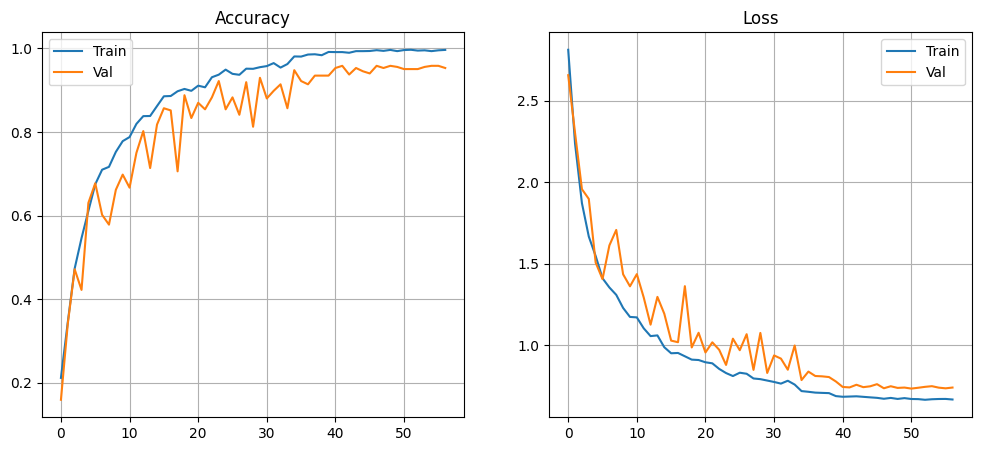

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


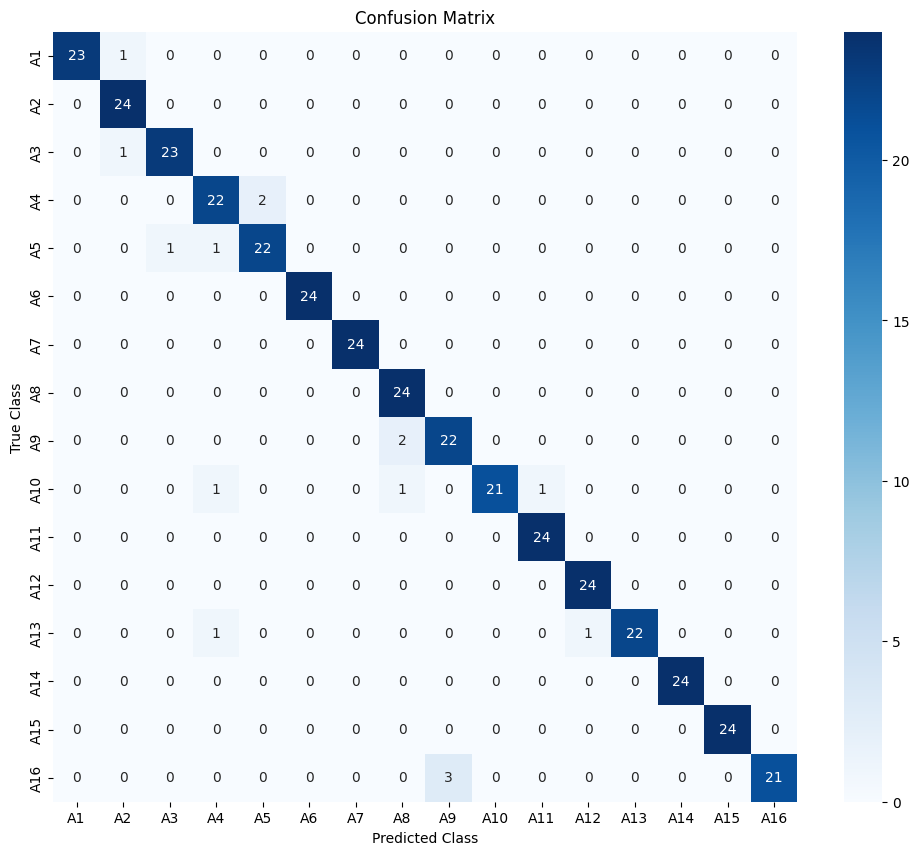


Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        24
           1       0.92      1.00      0.96        24
           2       0.96      0.96      0.96        24
           3       0.88      0.92      0.90        24
           4       0.92      0.92      0.92        24
           5       1.00      1.00      1.00        24
           6       1.00      1.00      1.00        24
           7       0.89      1.00      0.94        24
           8       0.88      0.92      0.90        24
           9       1.00      0.88      0.93        24
          10       0.96      1.00      0.98        24
          11       0.96      1.00      0.98        24
          12       1.00      0.92      0.96        24
          13       1.00      1.00      1.00        24
          14       1.00      1.00      1.00        24
          15       1.00      0.88      0.93        24

    accuracy                           0.96       384
 

In [16]:
# ==============================================================================
# 11. EVALUATE & PLOT
# ==============================================================================

print("\n--- Final Evaluation ---")
# Reload best weights to ensure we evaluate the best epoch
model.load_weights('best_wiar_final.h5')

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss:     {loss:.4f}")

# --- Plot Accuracy & Loss ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.grid(True)

plt.show()

# --- Confusion Matrix ---
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=[f"A{i}" for i in range(1, num_classes+1)],
    yticklabels=[f"A{i}" for i in range(1, num_classes+1)]
)
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, zero_division=0))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


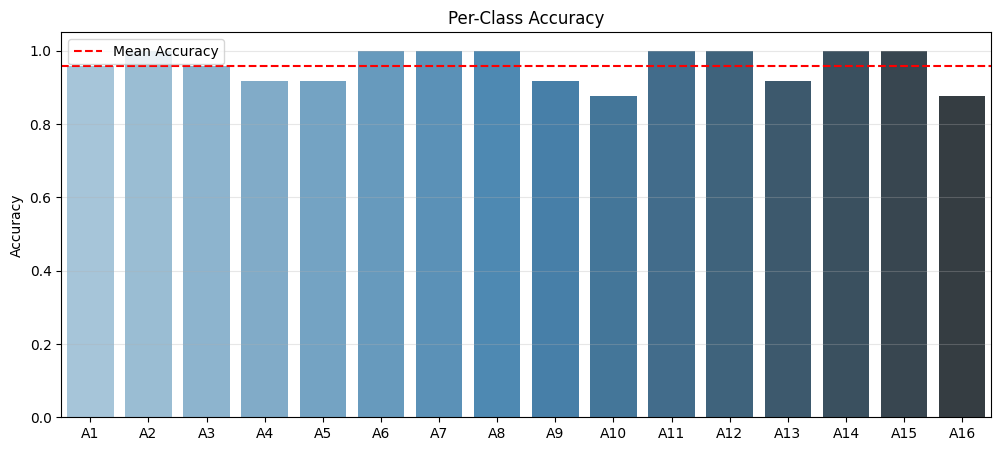

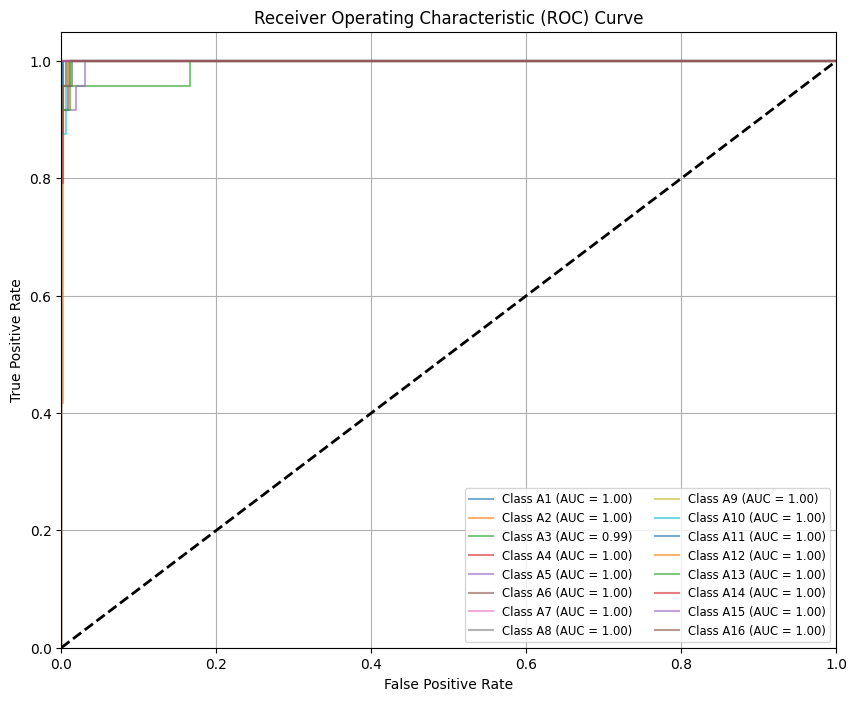

Generating T-SNE Plot (This might take a moment)...


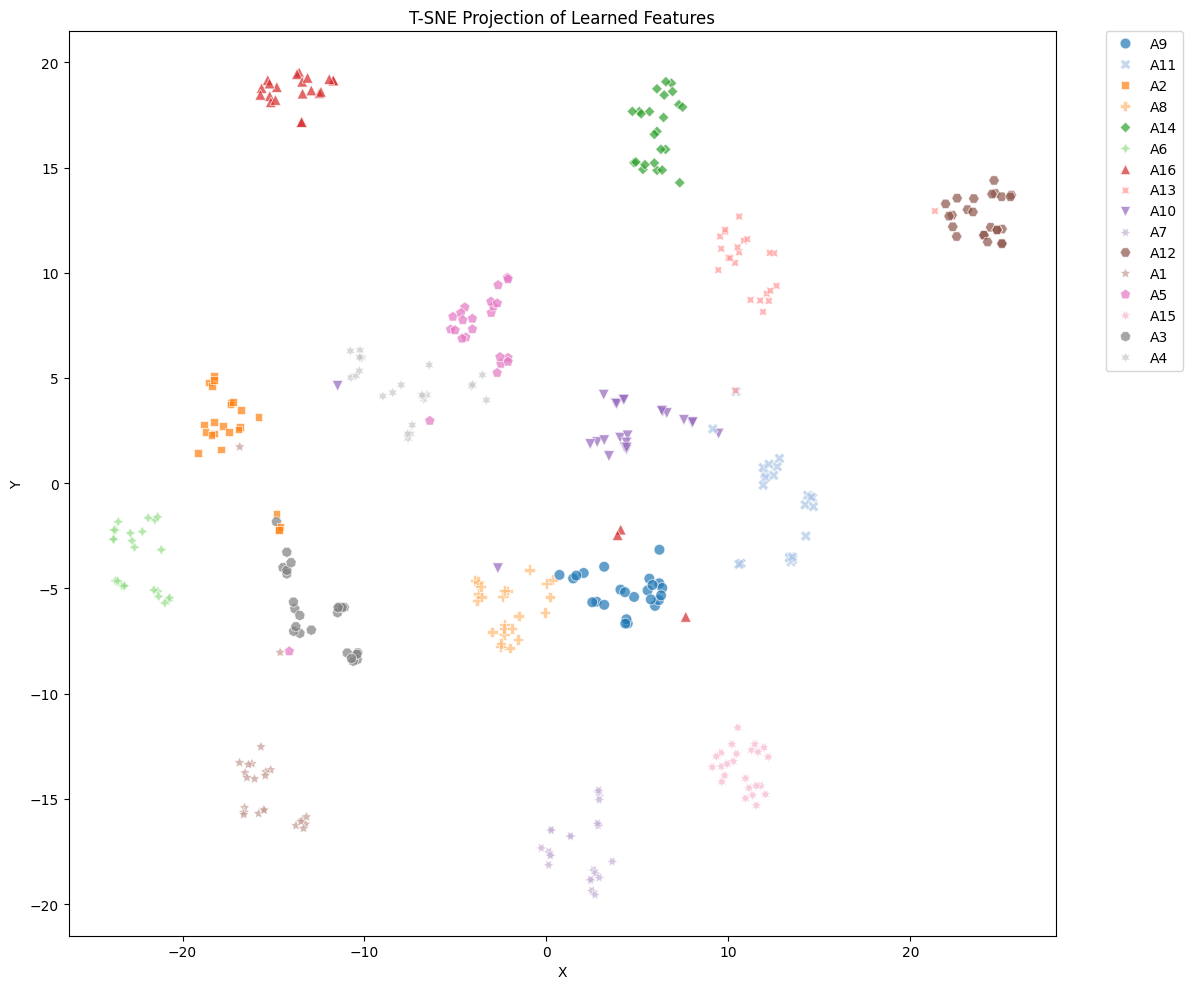

In [17]:
# ==============================================================================
# 12. ADVANCED VISUALIZATION (ROC, PER-CLASS, T-SNE)
# ==============================================================================
from sklearn.metrics import roc_curve, auc
from sklearn.manifold import TSNE

# Get predictions
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# -----------------------------------------------------------
# 1. PER-CLASS ACCURACY CHART
# -----------------------------------------------------------
matrix = confusion_matrix(y_true_classes, y_pred_classes)
class_accuracies = matrix.diagonal() / matrix.sum(axis=1)

plt.figure(figsize=(12, 5))
sns.barplot(x=[f"A{i+1}" for i in range(num_classes)], y=class_accuracies, palette="Blues_d")
plt.axhline(y=np.mean(class_accuracies), color='r', linestyle='--', label='Mean Accuracy')
plt.title("Per-Class Accuracy")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

# -----------------------------------------------------------
# 2. MULTI-CLASS ROC CURVES
# -----------------------------------------------------------
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=1.5, alpha=0.6, label=f'Class A{i+1} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right", ncol=2, fontsize='small')
plt.grid(True)
plt.show()

# -----------------------------------------------------------
# 3. T-SNE VISUALIZATION (Feature Embedding)
# -----------------------------------------------------------
print("Generating T-SNE Plot (This might take a moment)...")

# Create a truncated model that outputs the 'Dense' layer features (before softmax)
# We look for the layer named 'dense' (or the second to last layer)
feature_layer_name = None
for layer in model.layers:
    if "dense" in layer.name and "softmax" not in layer.name:
        feature_layer_name = layer.name
        # Break at the first dense layer (usually 128 units in your code)
        break

if feature_layer_name:
    feature_extractor = Model(inputs=model.input, outputs=model.get_layer(feature_layer_name).output)
    features = feature_extractor.predict(X_test, verbose=0)

    # Run T-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    X_embedded = tsne.fit_transform(features)

    # Plot
    plt.figure(figsize=(12, 10))
    df_tsne = pd.DataFrame(X_embedded, columns=['X', 'Y'])
    df_tsne['Label'] = [f"A{i+1}" for i in y_true_classes]

    sns.scatterplot(
        data=df_tsne, x='X', y='Y', hue='Label',
        palette='tab20', alpha=0.7, s=60, style='Label'
    )
    plt.title("T-SNE Projection of Learned Features")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    plt.show()
else:
    print("Could not find suitable Dense layer for T-SNE extraction.")